# John's House Price

### Importing Packages

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import time
import numpy as np
import pandas as pd # to read in csv
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


import nltk

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

### Load and Inspect Data

In [4]:
#Read in data & add "o_" prefix to demarcate which columns were the originals 

# house price data
train_df = pd.read_csv("data_raw\\train.csv").add_prefix('o_') 
test_df = pd.read_csv("data_raw\\test.csv").add_prefix('o_') 

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
print(train_df.dtypes)
train_df.head(2)

Train Shape: (1460, 81)
Test Shape: (1459, 80)
o_Id                 int64
o_MSSubClass         int64
o_MSZoning          object
o_LotFrontage      float64
o_LotArea            int64
                    ...   
o_MoSold             int64
o_YrSold             int64
o_SaleType          object
o_SaleCondition     object
o_SalePrice          int64
Length: 81, dtype: object


,o_Id,o_MSSubClass,o_MSZoning,o_LotFrontage,o_LotArea,o_Street,o_Alley,o_LotShape,o_LandContour,o_Utilities,...,o_PoolArea,o_PoolQC,o_Fence,o_MiscFeature,o_MiscVal,o_MoSold,o_YrSold,o_SaleType,o_SaleCondition,o_SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


### Check Missingness

In [5]:
# Raw data has several columns with missing data
train_df.isnull().sum(axis=0)[train_df.isnull().sum(axis=0) != 0]

o_LotFrontage      259
o_Alley           1369
o_MasVnrType         8
o_MasVnrArea         8
o_BsmtQual          37
o_BsmtCond          37
o_BsmtExposure      38
o_BsmtFinType1      37
o_BsmtFinType2      38
o_Electrical         1
o_FireplaceQu      690
o_GarageType        81
o_GarageYrBlt       81
o_GarageFinish      81
o_GarageQual        81
o_GarageCond        81
o_PoolQC          1453
o_Fence           1179
o_MiscFeature     1406
dtype: int64

In [6]:
# Code to see which sample Id has missing data
train_df["o_Id"][train_df["o_MasVnrType"].isnull()].unique()

array([ 235,  530,  651,  937,  974,  978, 1244, 1279], dtype=int64)

19


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000203E7696B08>,
      dtype=object)

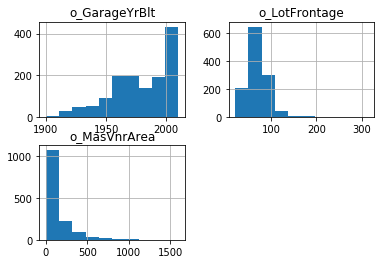

In [108]:
#historgram of the missing data
df_missing_data = train_df.isnull().sum(axis=0)[train_df.isnull().sum(axis=0) != 0].index
print(len(df_missing_data))

#plt.hist(train_df[null_columns])
#plt.scatter(train_df[null_columns])
train_df[df_missing_data].hist()

In [8]:
#Types of missing data
train_df[df_missing_data].dtypes

o_LotFrontage     float64
o_Alley            object
o_MasVnrType       object
o_MasVnrArea      float64
o_BsmtQual         object
o_BsmtCond         object
o_BsmtExposure     object
o_BsmtFinType1     object
o_BsmtFinType2     object
o_Electrical       object
o_FireplaceQu      object
o_GarageType       object
o_GarageYrBlt     float64
o_GarageFinish     object
o_GarageQual       object
o_GarageCond       object
o_PoolQC           object
o_Fence            object
o_MiscFeature      object
dtype: object

In [101]:
#drop columns with NA rows
train_df1=train_df.dropna(axis=1)
# check if dropping NA worked
train_df1.isnull().sum(axis=0)[train_df.isnull().sum(axis=0) != 0]

Series([], dtype: int64)

### Generate Summary Statistics

In [104]:
train_df.describe(include = 'all')

,o_Id,o_MSSubClass,o_MSZoning,o_LotFrontage,o_LotArea,o_Street,o_Alley,o_LotShape,o_LandContour,o_Utilities,...,o_PoolArea,o_PoolQC,o_Fence,o_MiscFeature,o_MiscVal,o_MoSold,o_YrSold,o_SaleType,o_SaleCondition,o_SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [103]:
train_df1.describe(include = 'all')

,o_Id,o_MSSubClass,o_MSZoning,o_LotArea,o_Street,o_LotShape,o_LandContour,o_Utilities,o_LotConfig,o_LandSlope,...,o_EnclosedPorch,o_3SsnPorch,o_ScreenPorch,o_PoolArea,o_MiscVal,o_MoSold,o_YrSold,o_SaleType,o_SaleCondition,o_SalePrice
count,1460.000000,1460.000000,1460,1460.000000,1460,1460,1460,1460,1460,1460,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,2,4,4,2,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,1454,925,1311,1459,1052,1382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,...,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,...,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,7553.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,9478.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,11601.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


### Check Duplicates

In [105]:
# There are no perfectly duplicated rows
sum(train_df1.duplicated())

0

### Train/Dev Data with a few columns

In [145]:
train_df1
sf_columns=['o_GrLivArea', 'o_TotalBsmtSF','o_SalePrice']
train_df2=train_df1[sf_columns]
train_df2
# LotArea: Lot size in square feet
# BsmtFinSF1: Type 1 finished square feet
# BsmtFinSF2: Type 2 finished square feet
# BsmtUnfSF: Unfinished square feet of basement area
# TotalBsmtSF: Total square feet of basement area    
# 1stFlrSF: First Floor square feet 
# 2ndFlrSF: Second floor square feet
# LowQualFinSF: Low quality finished square feet (all floors)
# GrLivArea: Above grade (ground) living area square feet    
# GarageArea: Size of garage in square feet
# WoodDeckSF: Wood deck area in square feet
# OpenPorchSF: Open porch area in square feet
# EnclosedPorch: Enclosed porch area in square feet
# 3SsnPorch: Three season porch area in square feet
# ScreenPorch: Screen porch area in square feet
# PoolArea: Pool area in square feet

,o_GrLivArea,o_TotalBsmtSF,o_SalePrice
0,1710,856,208500
1,1262,1262,181500
2,1786,920,223500
3,1717,756,140000
4,2198,1145,250000
...,...,...,...
1455,1647,953,175000
1456,2073,1542,210000
1457,2340,1152,266500
1458,1078,1078,142125


In [7]:
pd.plotting.scatter_matrix(train_df2)

NameError: name 'train_df2' is not defined

In [172]:
X = train_df2.iloc[:,:-1]
y = train_df2.iloc[:,-1]
train_data_bl, dev_data_bl, train_labels_bl, dev_labels_bl = train_test_split(X,y, test_size=0.2)  #for baseline

In [173]:
#Linear regression model
lr = LinearRegression(fit_intercept=True)
lr.fit(train_data_bl, train_labels_bl)                 #fit model
print ("Estimated function: y = %.2f + (x%d) w_i*x_i" %(lr.intercept_, len(lr.coef_)))
accuracies_prediction = lr.predict(dev_data_bl)    #predict
print("R^2:",lr.score(train_data_bl,train_labels_bl))    #Finding R^2
print("Accuracy:",lr.score(dev_data_bl,dev_labels_bl))    #Finding accuracy of dev data

Estimated function: y = -31172.60 + (x2) w_i*x_i
R^2: 0.6743590335776113
Accuracy: 0.28452377150115016


..........................................................................................
1. k-Nearest Neighbors:  
Best f1_score is 0.007 when K is 41


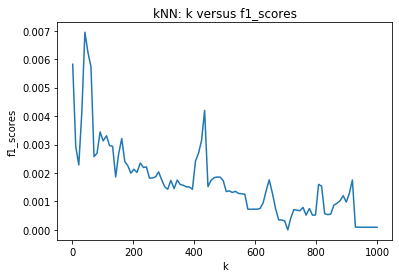

In [181]:
#K-Nearest Neighbors

print("."*90)
print("k-Nearest Neighbors:  ")
K= [int(x) for x in np.linspace(1,1000,100)]  
f1_scores = {}
for k in K:
    # k-Nearest Neighbors Model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_data_bl, train_labels_bl)  
    dev_predicted_labels = knn.predict(dev_data_bl)
    # finding, printing, and storing f1_score    
    f1_score = metrics.f1_score(dev_labels_bl, dev_predicted_labels, average='weighted')
    #print("For K: %d, f1_score: %.3f" %(k,f1_score))
    f1_scores[k] = f1_score
best = max(f1_scores, key=f1_scores.get)
print("Best f1_score is %.3f when K is %s" %(f1_scores[best],best))
#Plotting
fig1=plt.figure()
fig1=plt.title('kNN: k versus f1_scores')
fig1=plt.xlabel('k')
fig1=plt.ylabel('f1_scores')
fig1=plt.plot(list(f1_scores.keys()), list(f1_scores.values()))

..........................................................................................
Naive Bayes:  
Best f1_score is 0.003 when alpha is 1e-10


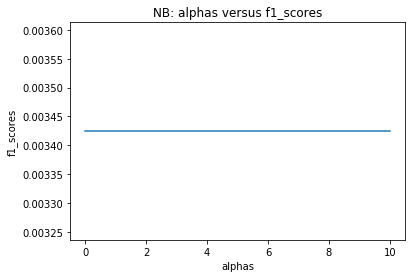

In [183]:
#Naive Bayes

print("."*90)
print("Naive Bayes:  ")
alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]  
#varying by magnitudes of alpha to capture a wide range of values
f1_scores = {}
for alpha in alphas:
    # Naive Bayes Model
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(train_data_bl, train_labels_bl)
    dev_predicted_labels = mnb.predict(dev_data_bl)
    # finding, printing, and storing f1_score    
    f1_score = metrics.f1_score(dev_labels_bl, dev_predicted_labels, average='weighted')
    #print("For Alpha: %s, f1_score: %.03f" %(alpha,f1_score))
    f1_scores[alpha] = f1_score
best = max(f1_scores, key=f1_scores.get)
print("Best f1_score is %0.03f when alpha is %s" %(f1_scores[best],best))
#Plotting
fig2=plt.figure()
fig2=plt.title('NB: alphas versus f1_scores')
fig2=plt.xlabel('alphas')
fig2=plt.ylabel('f1_scores')
#plt.xscale('log')
fig2=plt.plot(list(f1_scores.keys()), list(f1_scores.values()))

### Train/Dev Data with all columns

In [106]:
train_df1.shape

(1460, 62)

In [109]:
train_data = train_df1.iloc[0:1168,:-1].values
train_labels = train_df1.iloc[0:1168,-1].values
dev_data = train_df1.iloc[1168:,:-1].values
dev_labels = train_df1.iloc[1168:,-1].values
print('training data shape:', train_data.shape)
print('training label shape:', train_labels.shape)
print('dev dat shape:',      dev_data.shape)
print('dev label shape:',      dev_labels.shape)

training data shape: (1168, 61)
training label shape: (1168,)
dev dat shape: (292, 61)
dev label shape: (292,)


In [115]:
#Converted all categorical data to dummy variables
#columns expanded from 80 to 290
np.random.seed(0)

dummies_df = pd.get_dummies(train_df1)
X=dummies_df.drop(columns=['o_SalePrice'])
y=dummies_df['o_SalePrice'].values

#scale values between 0 and 1
features=X.columns.values
scaler=MinMaxScaler(feature_range=(0,1))
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X))
X.columns=features


train_data, dev_data, train_labels, dev_labels = train_test_split(X,y, test_size=0.2)
print('training data shape:', train_data.shape)
print('training label shape:', train_labels.shape)
print('dev dat shape:',      dev_data.shape)
print('dev label shape:',      dev_labels.shape)
train_data.head()

training data shape: (1168, 216)
training label shape: (1168,)
dev dat shape: (292, 216)
dev label shape: (292,)


,o_Id,o_MSSubClass,o_LotArea,o_OverallQual,o_OverallCond,o_YearBuilt,o_YearRemodAdd,o_BsmtFinSF1,o_BsmtFinSF2,o_BsmtUnfSF,...,o_SaleType_ConLw,o_SaleType_New,o_SaleType_Oth,o_SaleType_WD,o_SaleCondition_Abnorml,o_SaleCondition_AdjLand,o_SaleCondition_Alloca,o_SaleCondition_Family,o_SaleCondition_Normal,o_SaleCondition_Partial
618,0.423578,0.000000,0.048583,0.888889,0.50,0.978261,0.950000,0.008505,0.0,0.759418,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
870,0.596299,0.000000,0.024773,0.444444,0.50,0.652174,0.200000,0.000000,0.0,0.382705,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
92,0.063057,0.058824,0.056370,0.444444,0.75,0.355072,0.933333,0.126329,0.0,0.069777,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
817,0.559973,0.000000,0.055926,0.777778,0.50,0.942029,0.866667,0.215804,0.0,0.149829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
302,0.206991,0.000000,0.057978,0.666667,0.50,0.934783,0.866667,0.000000,0.0,0.659675,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [137]:
for each in  train_data.columns:
    print(each)

o_Id
o_MSSubClass
o_LotArea
o_OverallQual
o_OverallCond
o_YearBuilt
o_YearRemodAdd
o_BsmtFinSF1
o_BsmtFinSF2
o_BsmtUnfSF
o_TotalBsmtSF
o_1stFlrSF
o_2ndFlrSF
o_LowQualFinSF
o_GrLivArea
o_BsmtFullBath
o_BsmtHalfBath
o_FullBath
o_HalfBath
o_BedroomAbvGr
o_KitchenAbvGr
o_TotRmsAbvGrd
o_Fireplaces
o_GarageCars
o_GarageArea
o_WoodDeckSF
o_OpenPorchSF
o_EnclosedPorch
o_3SsnPorch
o_ScreenPorch
o_PoolArea
o_MiscVal
o_MoSold
o_YrSold
o_MSZoning_C (all)
o_MSZoning_FV
o_MSZoning_RH
o_MSZoning_RL
o_MSZoning_RM
o_Street_Grvl
o_Street_Pave
o_LotShape_IR1
o_LotShape_IR2
o_LotShape_IR3
o_LotShape_Reg
o_LandContour_Bnk
o_LandContour_HLS
o_LandContour_Low
o_LandContour_Lvl
o_Utilities_AllPub
o_Utilities_NoSeWa
o_LotConfig_Corner
o_LotConfig_CulDSac
o_LotConfig_FR2
o_LotConfig_FR3
o_LotConfig_Inside
o_LandSlope_Gtl
o_LandSlope_Mod
o_LandSlope_Sev
o_Neighborhood_Blmngtn
o_Neighborhood_Blueste
o_Neighborhood_BrDale
o_Neighborhood_BrkSide
o_Neighborhood_ClearCr
o_Neighborhood_CollgCr
o_Neighborhood_Crawfor
o

In [135]:
# NOT SURE IF DONE CORRECTLY

#Linear regression model
lr = LinearRegression(fit_intercept=True)
lr.fit(train_data, train_labels)                 #fit model
print ("Estimated function: y = %.2f + (x%d) w_i*x_i" %(lr.intercept_, len(lr.coef_)))
accuracies_prediction = lr.predict(dev_data)    #predict
print("R^2:",lr.score(train_data,train_labels))    #Finding R^2
print("Accuracy:",lr.score(dev_data,dev_labels))    #Finding accuracy of dev data

Estimated function: y = 40875054468671456.00 + (x216) w_i*x_i
R^2: 0.9306903028860848
Accuracy: -1.3151046340974787e+18


In [117]:
#logistic regression model
c=0.5
lr = LogisticRegression(C=c, solver="liblinear", multi_class="auto")  #default regularization = l2
lr.fit(train_data,train_labels)
dev_predicted_labels=lr.predict(dev_data)
# finding, printing, and storing f1_score    
f1_score=metrics.f1_score(dev_labels,dev_predicted_labels,average='weighted')
print("For C = %s, f1_score = %.3f" %(c,f1_score))

For C = 0.5, f1_score = 0.002
